In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("/xfs/home/tensor_zy/guoxuan/Task3/ChatGLM/inferencing")

In [2]:
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,recall_score,precision_score, auc
from tqdm import tqdm
import pandas as pd
import json, torch

from cover_alpaca2jsonl import format_example

In [3]:
model_path = "THUDM/chatglm2-6b"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device = "cuda")
model = AutoModel.from_pretrained(model_path, trust_remote_code=True, load_in_8bit=True, device_map = "auto")
# model = AutoModel.from_pretrained(model_path, trust_remote_code=True, device_map = "auto")
model = torch.compile(model)
model = model.eval()

[2023-07-26 19:27:43,557] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /xfs/home/tensor_zy/anaconda3/envs/isaacgym/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /xfs/home/tensor_zy/anaconda3/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

### Load Dataset

In [4]:
from datasets import load_dataset
import datasets

dataset = load_dataset("boolq")
dataset = dataset['validation']

Found cached dataset boolq (/xfs/home/tensor_zy/.cache/huggingface/datasets/boolq/default/0.1.0/bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = dataset.to_pandas()
dataset['answer'] = dataset['answer'].astype('str')
dataset.head(2)

,question,answer,passage
0,does ethanol take more energy make that produces,False,All biomass goes through at least some of thes...
1,is house tax and property tax are same,True,Property tax or 'house tax' is a local tax on ...


In [6]:
dataset.columns = ['instruction', 'output', 'input']

In [7]:
dataset[["context","target"]] = dataset.apply(format_example, axis = 1, result_type="expand")
dataset.head(2)

,instruction,output,input,context,target
0,does ethanol take more energy make that produces,False,All biomass goes through at least some of thes...,Instruction: does ethanol take more energy mak...,False
1,is house tax and property tax are same,True,Property tax or 'house tax' is a local tax on ...,Instruction: is house tax and property tax are...,True


In [8]:
context = dataset['context'].tolist()
len(context)

3270

In [9]:
batch_size = 32

total_steps = dataset.shape[0]//batch_size
total_steps

102

In [10]:

res_list = []
res_sentences_list = []
out_text_list = []

for i in tqdm(range(total_steps+1)):
    tmp_context = context[i* batch_size:(i+1)* batch_size]
    tokens = tokenizer(tmp_context, return_tensors='pt', padding=True, max_length=512)
    for k in tokens.keys():
        tokens[k] = tokens[k].cuda()
    
    res = model.generate(**tokens, max_length=512)
    res_sentences = [tokenizer.decode(i) for i in res]
    out_text = [o.split("Answer: ")[1] for o in res_sentences]
    res_list += res
    res_sentences_list += res_sentences
    out_text_list += out_text
    torch.cuda.empty_cache()

 37%|███▋      | 38/103 [04:50<08:16,  7.64s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 566.00 MiB (GPU 0; 39.59 GiB total capacity; 11.56 GiB already allocated; 155.19 MiB free; 14.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
res_list = [i.cpu() for i in res_list]

In [ ]:
dataset["res"] = res_list
dataset["res_sentences"] = res_sentences_list
dataset["out_text"] = out_text_list

In [ ]:
out_text_list[:10]

['1.34 units of fuel energy for each unit of energy expended',
 ' yes',
 '1. Yes.',
 ' yes',
 '1',
 ' no',
 '1',
 '71',
 '1.',
 '1.']

In [ ]:
out_text_list[:100]

['1.34 units of fuel energy for each unit of energy expended',
 ' yes',
 '1. Yes.',
 ' yes',
 '1',
 ' no',
 '1',
 '71',
 '1.',
 '1.',
 '1. Yes.',
 '2',
 '0',
 ' no',
 '2016 fantasy film directed by David Yates. A joint British and American production, it is a spin-off and prequel to the Harry Potter film series, and it was produced and written by J.K. Rowling in her screenwriting debut, and inspired by her 2001 book of the same name.',
 '1. yes',
 '2.',
 ' yes',
 '2018',
 '1',
 '1598 Main Street Unit 9975',
 ' yes',
 ' no',
 ' yes',
 '7th generation Fire 7 is not the same as the Kindle.',
 '18 - 20 year olds can drink alcohol with their parents in Wisconsin if they are with a parent, legal guardian, or spouse who is of legal drinking age.',
 '1. yes',
 '2.',
 ' yes',
 '14 holes outside the track , along the backstretch, and four holes in the infield.',
 '1',
 ' yes',
 ' no',
 ' no',
 ' yes',
 '2',
 '2',
 ' yes',
 '1',
 '0',
 ' no',
 ' yes',
 '1',
 ' no',
 '1',
 '1',
 ' yes',
 '4',
 '2'

In [ ]:
def change_target(x):
    if 'yes' in x or "1" in x:
        return "True"
    elif 'no' in x or '0' in x:
        return "False"
    else:
        return 'missing'

<AxesSubplot:>

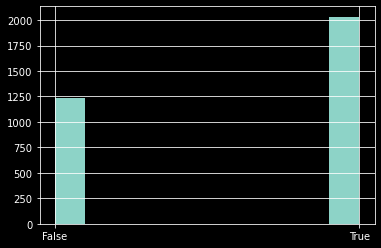

In [ ]:
# dataset["new_target"] = dataset["target"].apply(change_target)
dataset["new_target"] = dataset["target"]
dataset["new_target"].hist()

<AxesSubplot:>

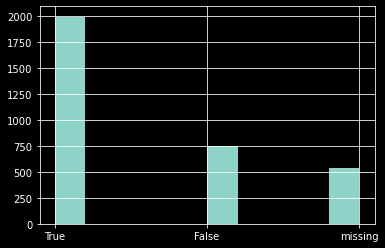

In [ ]:
dataset["new_out"] = dataset["out_text"].apply(change_target)
dataset["new_out"].hist()

### 8-bit

In [ ]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.5892966360856269

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.39939477273190566

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.5892966360856269

In [ ]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.6295356076439681

### Full

In [21]:
acc = accuracy_score(dataset["new_target"], dataset["new_out"])
acc

0.8327272727272728

In [22]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "macro")
f1

0.569713523470749

In [23]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "micro")
f1

0.8327272727272728

In [24]:
f1 = f1_score(dataset["new_target"], dataset["new_out"], average = "weighted")
f1

0.8010500482176782

In [27]:
dataset.to_csv("fiqa_ori.csv")

: 